# Segmentación de imágenes por algoritmo de Watershed

---

## Introducción

La segmentación de una imagen puede definirse como el proceso que consiste en subdividir una imagen en sus regiones, componentes, partes u objetos. Probablemente la imagen a segmentar ya fue pre procesada por medio de alguna de las técnicas de filtrado o mejorado de contraste existentes. La idea básica de la segmentación consiste en aislar en la imagen diferentes objetos a reconocer, respecto al fondo y entre ellos mismos. Tenemos claro que este proceso puede determinar el desempeño del sistema completo, ya que una mala segmentación provoca errores de detección o reconocimiento de los objetos en una imagen, y que al contrario, si tenemos una buena segmentación provoca que el sistema entregue los resultados adecuados.

---

## Algoritmo de Watershed (o Watershed Transform)

Basada en el concepto de **_"cuencas hidrográficas"_** por su traducción, donde los píxeles de una imagen se tratan como elevaciones en un **_paisaje topográfico_**. El objetivo es dividir la imagen en regiones o segmentos basados en la **_"inundación"_** de estas cuencas.



___
<hr>

### 1. Preprocesamiento:

* Convertir la imagen a escala de grises si no lo está.

* Aplicar filtros para reducir el ruido.

* De ser posible calcular el gradiente de la imagen para resaltar los bordes.

In [1]:
#Importaremos las librerias necesarias para este laboratorio
import numpy as np     #Libreria especializada en vectores y matrices de distintas magnitudes
import cv2 as cv       #Libreria desarrollada por OPENCV para procesamiento de imagénes
from matplotlib import pyplot as plt  #Libreria especializada en realizar graficos y análisis de datos
from IPython.display import Image, display, clear_output #Cargar y mostrar una imagen local en el cuaderno IPython.


In [2]:
#Seleccionamos y después Graficamos la imagen que segmentaremos
def imshow(img, ax=None):
	if ax is None:
		ret, encoded = cv.imencode(".jpg", img)
		display(Image(encoded))
	else:
		ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
		ax.axis('off')
        
img = cv.imread("2_mon.jpg")

In [4]:
#Conversión de la imagen a escala de grises
grey = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
clahe = cv.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
mcon = clahe.apply(grey)

In [5]:
#Debido a que la imagen tiene demasiados detalles le aplicaremos un filtro gausiano con kernel 9x9 suavizar la imagen
# y asi poder tener la menor cantidad de detalles y aprovechar los bordes exteriores que son los que nos importan al aplicar la binarización de Otsu
blur = cv.GaussianBlur(grey, (11, 11), 0)
clahe = cv.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
equ01 = clahe.apply(blur)

### 2. Aplicación de umbral

* En la segmentación de imágenes es la determinación del umbral, que convierte una imagen en escala de grises en una imagen binaria. Es esencial para distinguir los elementos que llaman la atención del fondo.

* Mediante el método de Otsu derminaremos automáticamente un umbral óptimo al maximizar la varianza entre dos clases de píxeles en la imagen. Su objetivo es encontrar un umbral que minimice la varianza intraclase y maximice la varianza interclase, separando efectivamente la imagen en dos grupos de píxeles con características distintas.

* El método de Otsu es conocido por su simplicidad y eficiencia computacional, lo que lo convierte en una opción popular en aplicaciones como el análisis de documentos, el reconocimiento de objetos y la obtención de imágenes médicas.

(np.float64(-0.5), np.float64(399.5), np.float64(395.5), np.float64(-0.5))

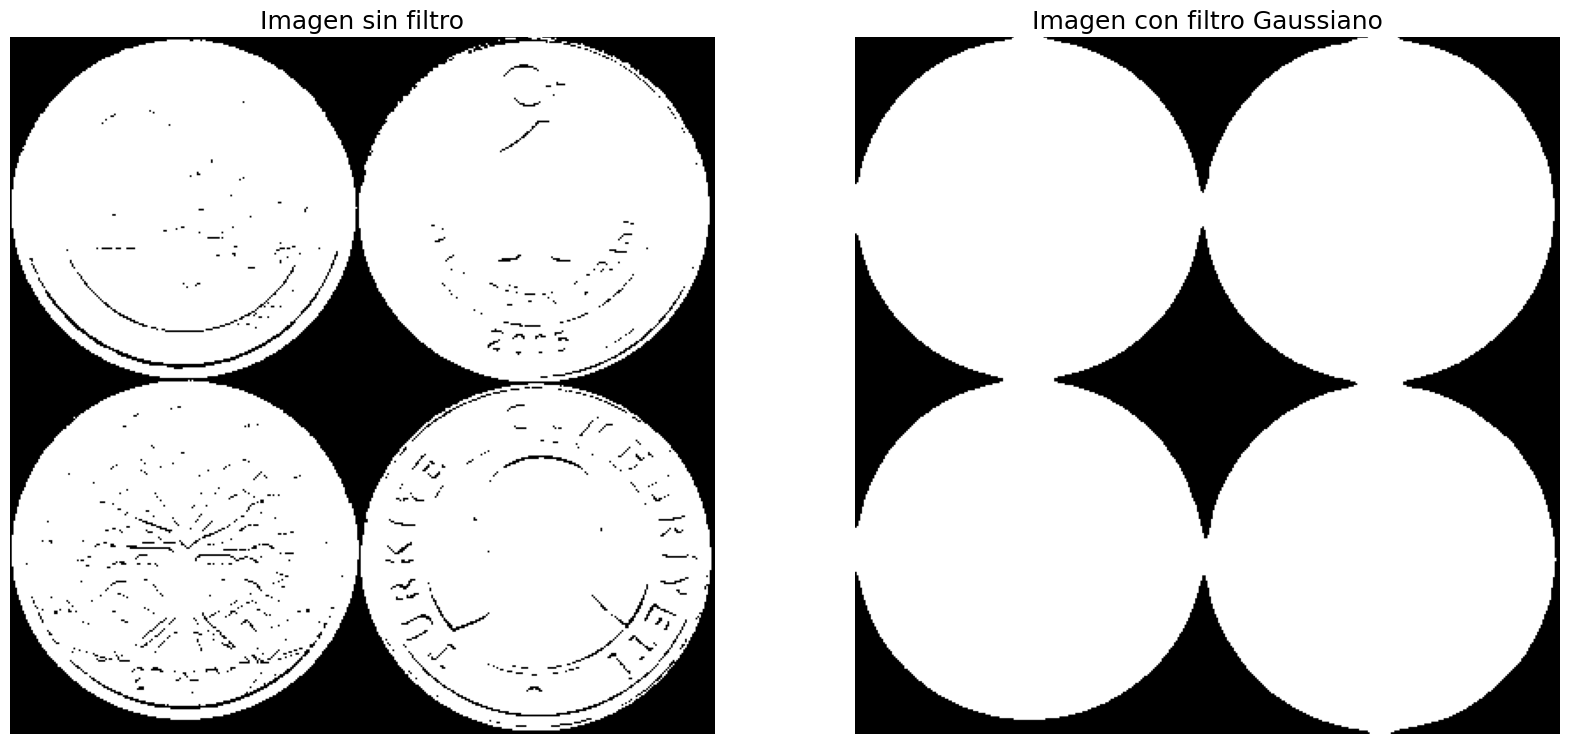

In [6]:
#Procesamiento de umbral, mostraremos la diferencia de la imagen con filtro y sin filtro

# Imagen sin ser procesada por filtro Gaussiano
ret, bin_img_0 = cv.threshold(grey,
							0, 255, 
							cv.THRESH_BINARY_INV + cv.THRESH_OTSU)


# Imagen con filro Gaussiano 9x9, podemos ver un mejor aprovechamiento con menor ruido
ret, bin_img = cv.threshold(blur,
							0, 255, 
							cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

plt.figure(figsize=(20, 13))

plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(bin_img_0,cv.COLOR_BGR2RGB))
plt.title("Imagen sin filtro", size=18)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(bin_img,cv.COLOR_BGR2RGB))
plt.title("Imagen con filtro Gaussiano", size=18)
plt.axis('off')


### 2.1 Eliminación de ruido con uso de procesamiento de gradiente morfológico

* El gradiente morfológico es una herramienta que se utiliza en el procesamiento de imágenes morfológicas para enfatizar los bordes y límites de los objetos en una imagen. Se obtiene restando la erosión de una imagen de su dilatación. La erosión encoge las regiones brillantes de una imagen, mientras que la dilatación las expande, y el gradiente morfológico representa la diferencia entre ambos.

In [7]:
# Eliminación de ruido restante de la imagen de salida de binarización de Otsu
kernel = cv.getStructuringElement(cv.MORPH_RECT, (15, 15))
bin_img = cv.morphologyEx(bin_img, 
						cv.MORPH_OPEN,
						kernel,
						iterations=2)

### 2.2 Detección del fondo y primer plano negros de la imagen

* Tenemos que conseguir la zona negra, que es la parte de fondo de esta imagen. Si la parte blanca es la zona requerida y está bien rellena, eso significa que el resto es el fondo.
  

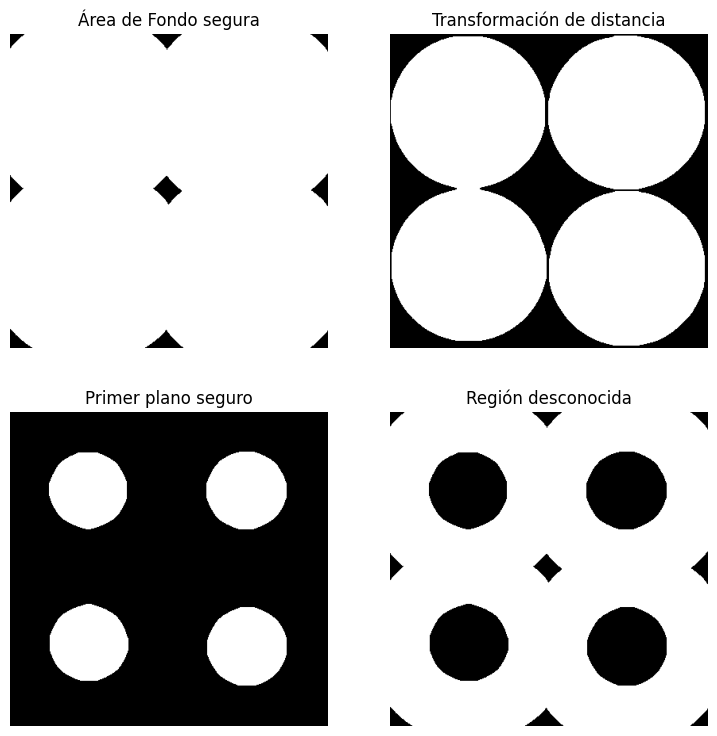

In [8]:
# Graficaremos los resultados 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
# Área de fondo segura, obtenida de expandir las regiones brillantes de la imagen.
sure_bg = cv.dilate(bin_img, kernel, iterations=3)
imshow(sure_bg, axes[0,0])
axes[0, 0].set_title('Área de Fondo segura')

# Transformación de distancia, calcula la distancia de cada pixel blanco de la imagen binaria al píxel negro más cercano.
dist = cv.distanceTransform(bin_img, cv.DIST_L2, 5)
imshow(dist, axes[0,1])
axes[0, 1].set_title('Transformación de distancia')

# Área de primer plano, se aplica umbral .5 veces el valor máximo de distancia
ret, sure_fg = cv.threshold(dist, 0.5 * dist.max(), 255, cv.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
imshow(sure_fg, axes[1,0])
axes[1, 0].set_title('Primer plano seguro')

# Región desconocida, es la diferencia entre las áreas seguras de fondo y primer plano
unknown = cv.subtract(sure_bg, sure_fg)
imshow(unknown, axes[1,1])
axes[1, 1].set_title('Región desconocida')

clear_output()

plt.show()

### 2.3 Identificación de marcadores

* La imagen es creada al etiquetar el primer plano seguro y en marcar la región desconocida, lo cual nos sirve como referencia para poder aplicar el algoritmo de Watershed. De esta manera al algoritmo es guiado en la segmentación de la imagen en función de as regiones etiquedatas, podemos observar que cada color o etiqueta distinto representa un segmento o región separado en la imagen.

* Estos marcadores representan las regiones que se inundarán.

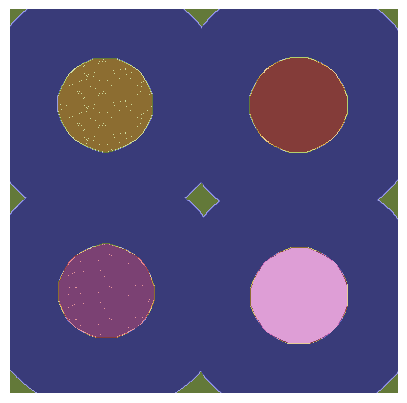

In [9]:
# Etiquetado de marcadores
# Primer plano seguro
ret, markers = cv.connectedComponents(sure_fg)

# Agrega uno a todas las etiquetas para que el fondo no sea 0, sino 1
markers += 1
# marca la región desconocida con cero
markers[unknown == 255] = 0

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()


### 2.5 Aplicar la transformada Watershed:

* Inundar la imagen desde los marcadores.

* Un bucle itera sobre las etiquetas comenzando desde 2 (ignorando el fondo y las regiones desconocidas) para extraer los contornos de cada objeto.
* Los contornos de la imagen binaria se encuentran utilizando la función “findContours” de OpenCV, y el primer contorno se agrega a una lista de monedas.
* Finalmente, se dibujan los contornos de los objetos sobre la imagen original con la función “cv2.drawContours”.
* Cuando las regiones inundadas se encuentran, se traza una línea divisoria (watershed).

(np.float64(-0.5), np.float64(399.5), np.float64(395.5), np.float64(-0.5))

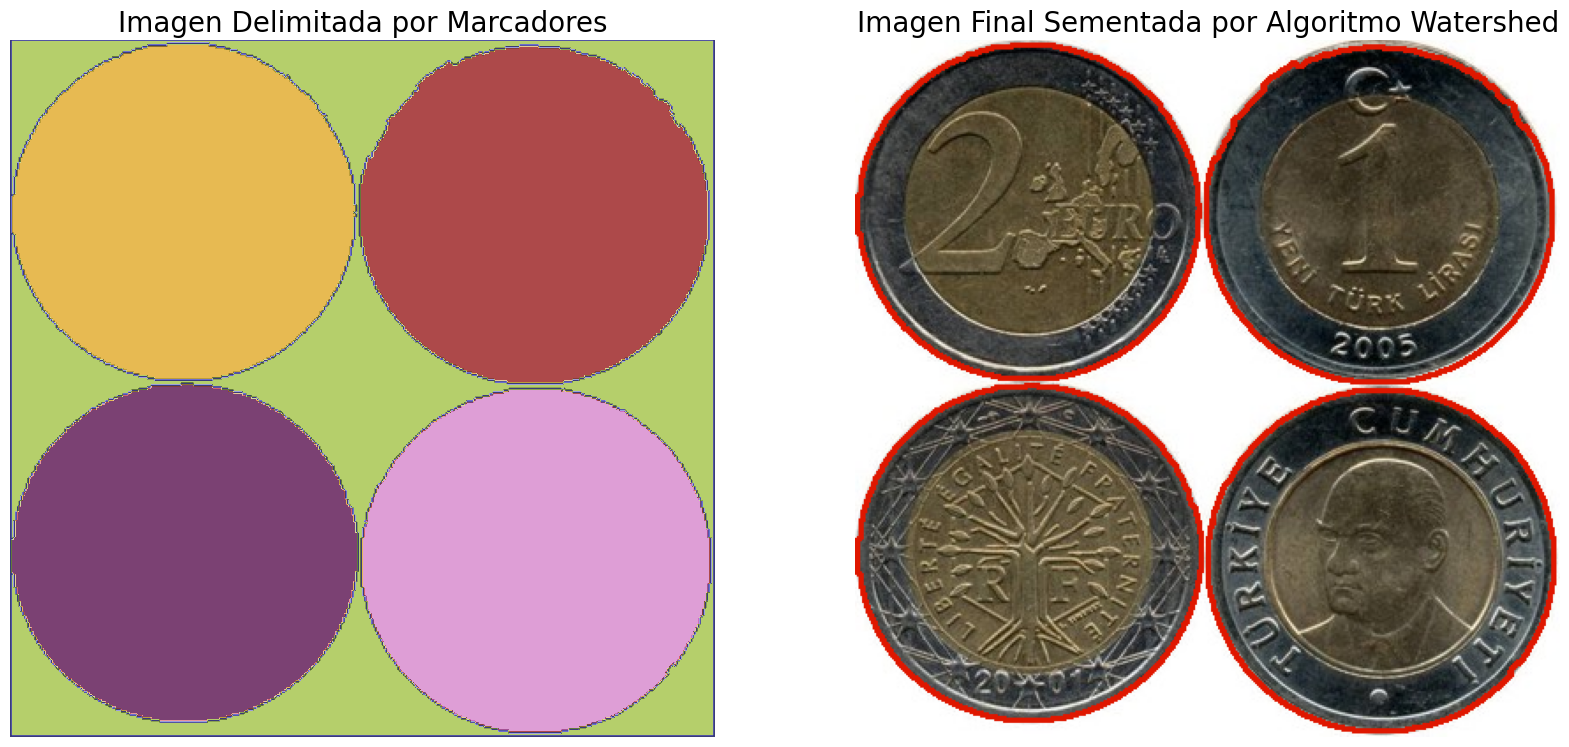

In [10]:
# Algoritmo de watershed

markers = cv.watershed(img, markers)

labels = np.unique(markers)

coins = []
for label in labels[2:]: 

#  Crea una imagen binaria en la que solo el área de la etiqueta esté en primer plano y el resto de la imagen esté en segundo plano
	target = np.where(markers == label, 255, 0).astype(np.uint8)

# Realizar la extracción de contorno en la imagen binaria creada
	contours, hierarchy = cv.findContours(
		target, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE
	)
	coins.append(contours[0])

# Dibuja el contorno
img = cv.drawContours(img, coins, -1, color=(0, 23, 223), thickness=2)

plt.figure(figsize=(20, 13))

plt.subplot(1, 2, 1)
plt.imshow(markers, cmap="tab20b")
plt.title("Imagen Delimitada por Marcadores", size=20)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
plt.title("Imagen Final Sementada por Algoritmo Watershed", size=20)
plt.axis('off')

---

### 3. Conclusiones

* Este algoritmo de segmentación de acuerdo a lo experimentado es muy sensible al ruido y puede producir sobre segmentación si no se realiza adecuadamente la selección de los marcadores, consideramos que para evitar la sobre segmentación, es recomendado utilizar técnicas como la distancia euclidiana o la marcación manual de las regiones, como se realizó en el desarrollo en los anteriores pasos.
* El área de aplicación que consideramos donde podría aplicarse es en la segmentación de objetos en imágenes médicas, procesamiento de imágenes biológicas, y análisis de imágenes del espacio.
* Es una herramienta muy útil en la visión por computadora cuando es bien implementada.

### 4. Bibliografía.
1. Sossa Azuela & Reyes Cortés. (2020). “Inteligencia Artificial Aplicada a Robótica y Automatización”
2. C. Gonzalez & E. Woods. (2017). “Digital Image Processing, Global Edition”
3. @misc{bartos_2020,
    title  = {pysheds: simple and fast watershed delineation in python},
    author = {Bartos, Matt},
    url    = {https://github.com/mdbartos/pysheds},
    year   = {2020},
    doi    = {10.5281/zenodo.3822494}
}